# Length binned gradient boosting classifier

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
from __future__ import annotations

from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.parallel_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Get ready to read the input data:

In [2]:
# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

Let's also make a data structure to collect results for plotting as we go.

In [3]:
# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Make a dictionary of scoring functions to be used as metrics:

In [4]:
# Make evaluation metrics scorers
scoring_funcs = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

## 2. Baseline performance
### 2.1. Cross-validation

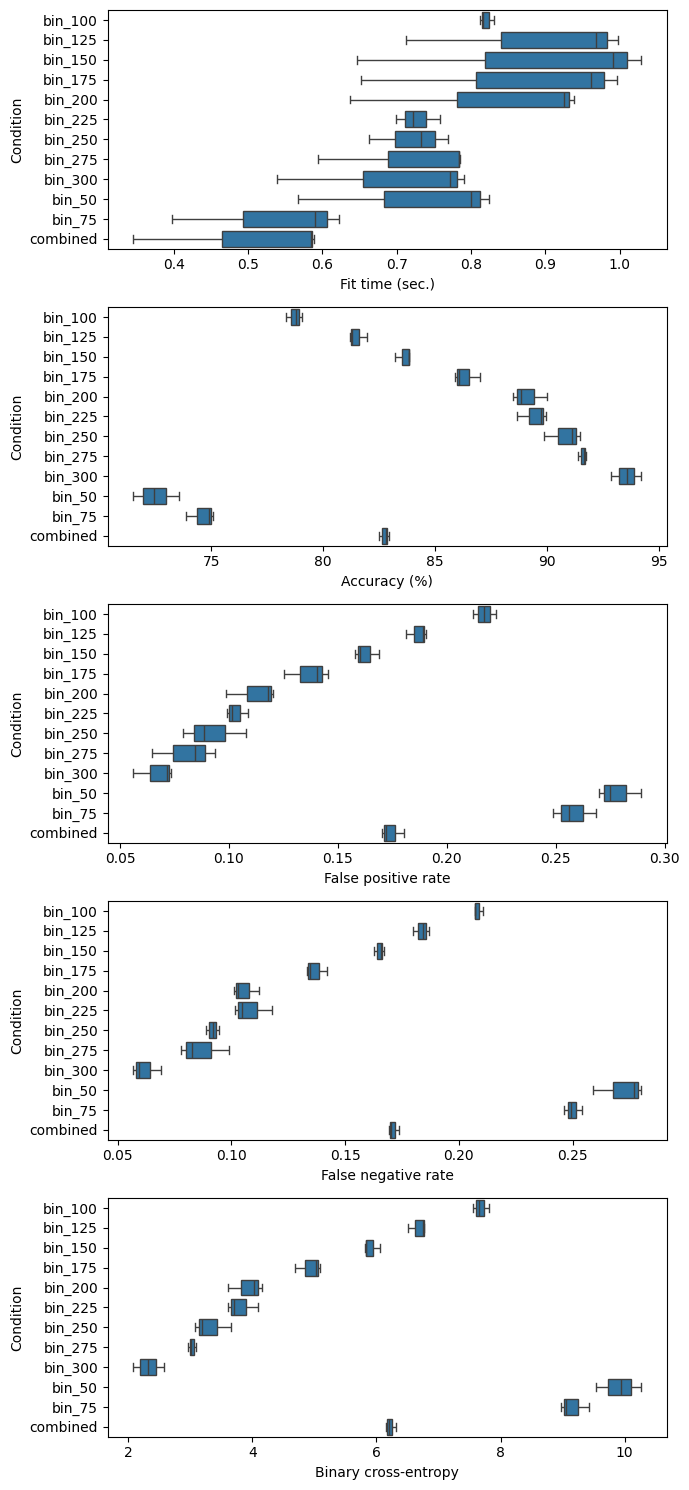

In [5]:
parsed_results = xgb_funcs.cross_validate_bins(input_file, scoring_funcs, parsed_results, 5)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

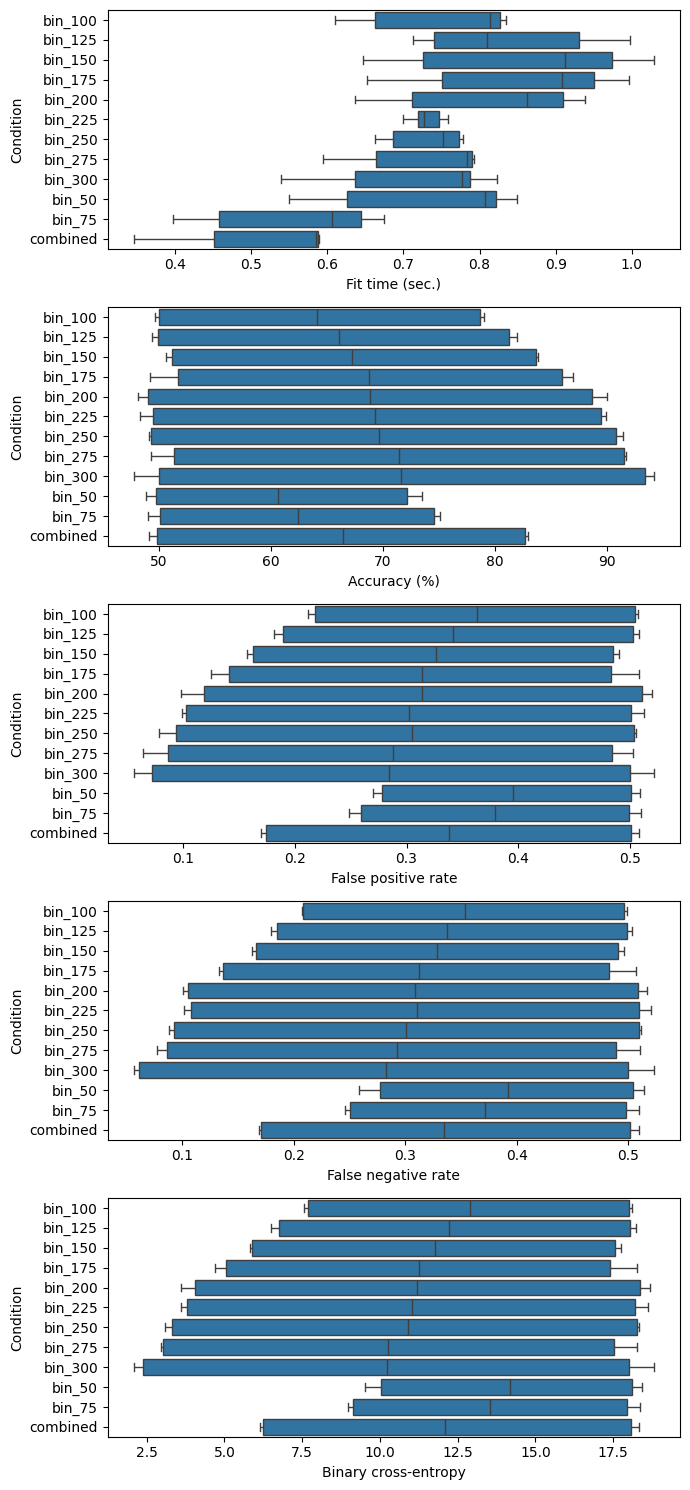

In [6]:
parsed_results = xgb_funcs.cross_validate_bins(input_file, scoring_funcs, parsed_results, 5, shuffle_control = True)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. We may be in trouble on short text fragments - we don't get to 90% accuracy until bin 250 which contains fragments between 151 and 250 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

I think that's it for tonight, more tomorrow. Already have some thoughts about how to deal with the overlapping bins and combining the outputs from the parallel classifiers...
